<a href="https://colab.research.google.com/github/HyoJuJang/traffic/blob/master/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BASELINE

### Library

In [ ]:
import numpy as np
import pandas as pd
import pickle
from glob import glob

In [ ]:
# for modeling
import tensorflow as tf
from tensorflow.keras.applications import VGG16 # 가벼운 모델
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/2021_2/dacon/go_traffic_file'

action_information = pd.read_csv(data_path + '/action_information.csv')
classes = pd.get_dummies(action_information[['Label']], columns = ['Label']).to_numpy()

# Modeling

In [ ]:
## train, valid 데이터 불러오기 : test_size = 0.2

path = data_path+'/train_array/train_valid'

#train_idx = np.load(glob(path+'train_idx.npy'))
#valid_idx = np.load(glob(path+'valid_idx.npy'))
X_train = np.load(path+'/train_X.npy')
y_train = np.load(path+'/train_y.npy')
X_valid = np.load(path+'/valid_X.npy')
y_valid = np.load(path+'/valid_y.npy')

In [ ]:
print('X_train shape : ', X_train.shape)
print('X_valid shape : ', X_valid.shape)
print('y_train shape : ', y_train.shape)
print('y_valid shape : ', y_valid.shape)

X_train shape :  (17774, 224, 224, 3)
X_valid shape :  (4444, 224, 224, 3)
y_train shape :  (17774, 6)
y_valid shape :  (4444, 6)


In [ ]:
len(y_train)

17774

In [ ]:
X_train[0][0][0]

array([0.3765, 0.4707, 0.1726], dtype=float16)

In [ ]:
trainAug = ImageDataGenerator(
    rotation_range = 30,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = False,
    fill_mode='nearest'
)
validAug = ImageDataGenerator()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD

In [ ]:
classes[1]

array([0, 1, 0, 0, 0, 0], dtype=uint8)

In [ ]:
baseModel = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(512, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(classes[1]), activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
  layer.trainable = False

print("[INFO] compiling modeling...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

[INFO] compiling modeling...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
tf.config.set_soft_device_placement(True)
history_m2 = model.fit(
            X_train, y_train, 
            validation_data = (X_valid,y_valid),
            verbose = 1,
            batch_size = 10,
            epochs=5,
                   )

In [ ]:
baseModel = VGG16(input_shape = (224,224,3), weights='imagenet', include_top=False, )
baseModel.trainable = False

model_in = Input(shape = (224,224,3))
base_model = baseModel(model_in)
head_model = MaxPooling2D(pool_size=(7, 7))(base_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(32, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(8, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)

model_out = Dense(classes.shape[1], activation="softmax")(head_model)

model = Model(inputs=model_in, outputs=model_out)

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
tf.config.set_soft_device_placement(True)
tf.test.gpu_device_name()

''

In [ ]:
tf.config.set_soft_device_placement(True)
history = model.fit(
            X_train, y_train, 
            validation_data = (X_valid,y_valid),
            verbose = 1,
            batch_size = 10,
            epochs=1,
                   )

In [ ]:
his_path = data_path + '/models'
with open (his_path+'/history', 'rb') as file:
  his1 = pickle.load(file)
with open (his_path+'/history_resnet1', 'rb') as file:
  his2 = pickle.load(file)

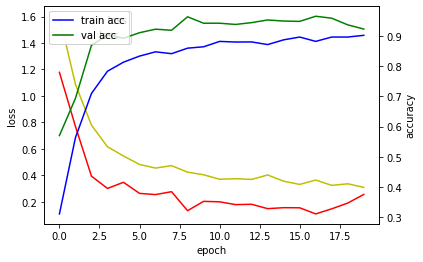

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(his1['loss'], 'y', label='train loss')
loss_ax.plot(his1['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(his1['accuracy'], 'b', label='train acc')
acc_ax.plot(his1['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

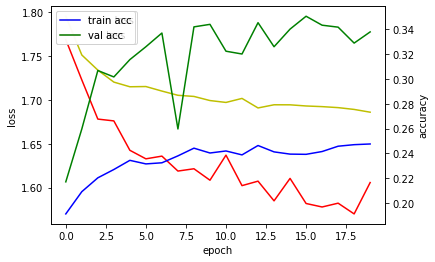

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(his2['loss'], 'y', label='train loss')
loss_ax.plot(his2['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(his2['accuracy'], 'b', label='train acc')
acc_ax.plot(his2['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
new_test_image_directory = new_image_directory + '/test'
new_test_image_directories = sorted(glob(new_test_image_directory + '/*'), key = lambda x : int(x.split('file_')[-1]))

predictions = []
for new_test_image_directory in tqdm(new_test_image_directories, total = len(new_test_image_directories)) :
    image_paths = sorted(glob(new_test_image_directory + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
    image_len = len(image_paths)
    test_images  = []
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img/255
        test_images.append(img)
    prediction = np.mean(model.predict(np.array(test_images)), axis = 0)
    predictions.append(prediction)

0it [00:00, ?it/s]


In [ ]:
predictions

[]

혹시 몰라서 copy

In [ ]:
print(images.shape)
print(targets.shape)

(22218, 224, 224, 3)
(22218, 6)


In [ ]:
train_idx, valid_idx = train_test_split(range(images.shape[0]), test_size = 0.2, stratify = stratify)

X_train = images[train_idx]
y_train = targets[train_idx]

X_valid = images[valid_idx]
y_valid = targets[valid_idx]

print('X_train shape : ', X_train.shape)
print('X_valid shape : ', X_valid.shape)
print('y_train shape : ', y_train.shape)
print('y_valid shape : ', y_valid.shape)

X_train shape :  (17774, 224, 224, 3)
X_valid shape :  (4444, 224, 224, 3)
y_train shape :  (17774, 6)
y_valid shape :  (4444, 6)


In [ ]:
baseModel = VGG16(input_shape = (224,224,3), weights='imagenet', include_top=False, )
baseModel.trainable = False

model_in = Input(shape = (224,224,3))
base_model = baseModel(model_in)
head_model = MaxPooling2D(pool_size=(7, 7))(base_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(32, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(8, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)

model_out = Dense(classes.shape[1], activation="softmax")(head_model)

model = Model(inputs=model_in, outputs=model_out)

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
history = model.fit(
            X_train, y_train, 
            validation_data = (X_valid,y_valid),
            verbose = 1,
            batch_size = 512,
            epochs=20,
                   )

Epoch 1/20
35/35 [==============================] - 21s 585ms/step - loss: 1.8091 - accuracy: 0.1786 - val_loss: 1.7915 - val_accuracy: 0.1791
Epoch 2/20
35/35 [==============================] - 20s 572ms/step - loss: 1.7842 - accuracy: 0.1962 - val_loss: 1.7554 - val_accuracy: 0.2565
Epoch 3/20
35/35 [==============================] - 20s 577ms/step - loss: 1.7489 - accuracy: 0.2432 - val_loss: 1.6933 - val_accuracy: 0.3510
Epoch 4/20
35/35 [==============================] - 20s 573ms/step - loss: 1.6501 - accuracy: 0.3006 - val_loss: 1.5116 - val_accuracy: 0.4370
Epoch 5/20
35/35 [==============================] - 20s 573ms/step - loss: 1.4607 - accuracy: 0.4221 - val_loss: 1.1799 - val_accuracy: 0.6503
Epoch 6/20
35/35 [==============================] - 20s 573ms/step - loss: 1.2116 - accuracy: 0.5340 - val_loss: 0.8793 - val_accuracy: 0.7538
Epoch 7/20
35/35 [==============================] - 20s 575ms/step - loss: 1.0142 - accuracy: 0.6247 - val_loss: 0.6756 - val_accuracy: 0.8141

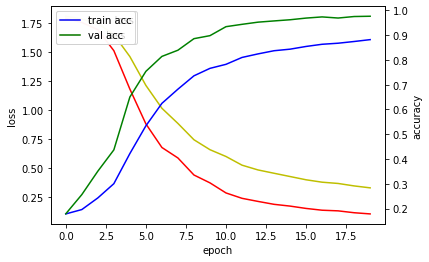

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
new_test_image_directory = new_image_directory + '/test'
new_test_image_directories = sorted(glob(new_test_image_directory + '/*'), key = lambda x : int(x.split('file_')[-1]))

predictions = []
for new_test_image_directory in tqdm(new_test_image_directories, total = len(new_test_image_directories)) :
    image_paths = sorted(glob(new_test_image_directory + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
    image_len = len(image_paths)
    test_images  = []
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img/255
        test_images.append(img)
    prediction = np.mean(model.predict(np.array(test_images)), axis = 0)
    predictions.append(prediction)

100%|██████████| 45/45 [00:15<00:00,  2.99it/s]


In [ ]:
sample_submission.iloc[:,1:] = predictions
display(sample_submission.head())
sample_submission.to_csv('./BASELINE.csv', index=False)

,file_path,Label_0,Label_1,Label_2,Label_3,Label_4,Label_5
0,./test\file_142,0.048860,0.029996,0.253161,0.269593,0.033256,0.365135
1,./test\file_143,0.004876,0.003066,0.098355,0.130929,0.034184,0.728591
2,./test\file_144,0.036387,0.005520,0.043648,0.833246,0.010118,0.071081
3,./test\file_145,0.012213,0.015196,0.609207,0.054274,0.015465,0.293646
4,./test\file_146,0.861626,0.011323,0.014597,0.024359,0.059995,0.028100
